In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import csv
import os

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & val loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['val'], c='tab:cyan', label='val')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [3]:
# Install a package to download data from Kaggle
!pip install -q opendatasets


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!kaggle competitions download -c ml2021spring-hw1

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\hp\anaconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\hp\anaconda3\Lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "C:\Users\hp\anaconda3\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\hp\.kaggle. Or use the environment method.


In [5]:
import opendatasets as od

od.download('https://www.kaggle.com/competitions/ml2021spring-hw1')

Skipping, found downloaded files in ".\ml2021spring-hw1" (use force=True to force download)


In [6]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=True):
        # read and process data
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            feats = [i for i in range(40) + [57, 75]]
            pass

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/val sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & val sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'val':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        self.data[:, 40:] = (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'val']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

In [7]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

In [8]:
tr_path = 'ml2021spring-hw1/covid.train.csv'  # path to training data
tt_path = 'ml2021spring-hw1/covid.test.csv'   # path to testing data
target_only = False                   # TODO: Using 40 states & 2 tested_positive features
tr_set = prep_dataloader(tr_path, 'train', 270, target_only=target_only)
vl_set = prep_dataloader(tr_path, 'val', 270, target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', 270, target_only=target_only)

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 93)
Finished reading the val set of COVID19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 93)


In [9]:
class NeuralNet(nn.Module):
    ''' A simple fully-connected deep neural network '''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        # Define your neural network here
        # How to modify this model to achieve better performance?

        # TODO:
        # Define a two-layer neural network with a ReLU activation function after the first layer, no activation layer for the second layer
        # You have 64 hidden states
        self.linear_1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(64, 1)

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        # TODO: define your forward pass
        x=self.linear_1(x)
        x=self.relu(x)
        x=self.linear_2(x)
        return x.squeeze(1) # remove the redundant dimension (bs, 1) -> (bs, )

In [10]:
device = get_device()
model = NeuralNet(tr_set.dataset.dim).to(device)

In [11]:
criterion = nn.MSELoss()

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [14]:
def train(tr_set, dv_set, model, criterion, optimizer, save_path, device):
    ''' DNN training '''

    n_epochs = 1000  # Maximum number of epochs

    min_mse = 1000.
    loss_record = {'train': [], 'val': []}      # for recording training loss
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero
            x, y = x.to(device), y.to(device)   # move data to device (cpu/cuda)
            # TODO:
            # forward pass (compute output)
            # compute loss and name it as mse_loss
            # compute gradient (backpropagation)
            # update model with optimizer
            pred = model(x)
            mse_loss = criterion(pred, y)
            mse_loss.backward()
            optimizer.step()

            loss_record['train'].append(mse_loss.detach().cpu().item()) # record loss

        # After each epoch, test your model on the validation (development) set.
        val_mse = val(dv_set, model, criterion, device)
        if val_mse < min_mse:
            # Save model if your model improved
            min_mse = val_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), save_path)  # Save model to specified path

        epoch += 1
        loss_record['val'].append(val_mse)

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

In [15]:
def val(dv_set, model, criterion, device):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        x, y = x.to(device), y.to(device)       # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            mse_loss = criterion(pred, y)  # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

In [16]:
def test(tt_set, model, device):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        x = x.to(device)                        # move data to device (cpu/cuda)
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds

In [17]:
model_loss, model_loss_record = train(tr_set, vl_set, model, criterion, optimizer, save_path='model.pth', device=device)

Saving model (epoch =    1, loss = 78.8524)
Saving model (epoch =    2, loss = 37.6170)
Saving model (epoch =    3, loss = 26.1203)
Saving model (epoch =    4, loss = 16.1861)
Saving model (epoch =    5, loss = 9.7153)
Saving model (epoch =    6, loss = 6.3701)
Saving model (epoch =    7, loss = 5.1802)
Saving model (epoch =    8, loss = 4.4255)
Saving model (epoch =    9, loss = 3.8009)
Saving model (epoch =   10, loss = 3.3691)
Saving model (epoch =   11, loss = 3.0943)
Saving model (epoch =   12, loss = 2.8176)
Saving model (epoch =   13, loss = 2.6274)
Saving model (epoch =   14, loss = 2.4542)
Saving model (epoch =   15, loss = 2.3012)
Saving model (epoch =   16, loss = 2.1766)
Saving model (epoch =   17, loss = 2.0641)
Saving model (epoch =   18, loss = 1.9399)
Saving model (epoch =   19, loss = 1.8978)
Saving model (epoch =   20, loss = 1.7950)
Saving model (epoch =   21, loss = 1.7164)
Saving model (epoch =   22, loss = 1.6455)
Saving model (epoch =   23, loss = 1.5912)
Saving 

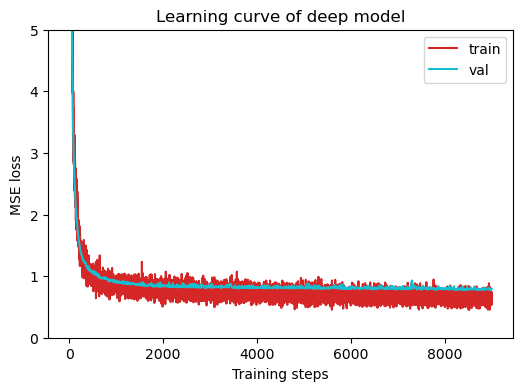

In [18]:
plot_learning_curve(model_loss_record, title='deep model')

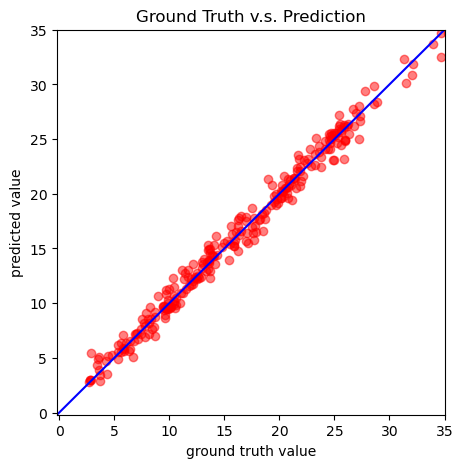

In [19]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load('model.pth', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(vl_set, model, device)  # Show prediction on the validation set

In [20]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
